In [1]:
%matplotlib inline
import pandas as pd
from random import randint

### Preprocessing and combine courses from websites

In [2]:
Udemy_CD = pd.read_csv('Udemy_course_description_Moving_Along_towards_Product.csv', encoding='utf-8')
for col in Udemy_CD.columns:
    Udemy_CD[col].fillna(' ', inplace = True)
Udemy_CD['training_string'] = Udemy_CD.course_des + ' ' + Udemy_CD.curriculum + ' ' + Udemy_CD.requirements
Udemy_CD['site_course_name'] = 'Udemy_' + Udemy_CD.course_name
Udemy_train = dict(zip(Udemy_CD.site_course_name, Udemy_CD.training_string))

In [3]:
Coursera_CD = pd.read_csv('Coursera_course_description.csv', encoding='utf-8')
for col in Coursera_CD.columns:
    Coursera_CD[col].fillna(' ', inplace = True)
Coursera_CD['training_string'] = Coursera_CD.course_des + ' ' + Coursera_CD.syllabus
Coursera_CD['site_course_name'] = 'Coursera_' + Coursera_CD['full_name']
Coursera_train = dict(zip(Coursera_CD.site_course_name, Coursera_CD.training_string))

In [4]:
Udemy_Coursera_combined_train = dict(Udemy_train, **Coursera_train)

In [5]:
print Udemy_CD.shape
print Coursera_CD.shape
print len(Udemy_Coursera_combined_train)

(2231, 11)
(798, 8)
2860


#### Text preprocessing - stemming and removing non-English words

In [8]:
import gensim
from gensim.corpora import TextCorpus, MmCorpus, Dictionary
import nltk
import enchant
import pickle

In [9]:
d = enchant.Dict('en_US')
def paragraph_stemmer(string): #and non english word remover
    porter = nltk.stem.porter.PorterStemmer()
    try:
        string = str(string)
        string = string.encode('utf-8')
    except:
        string = string.encode('utf-8')
        string = str(string)

    string = string.replace('\n',' ').replace(',',' ').replace('.',' ').replace('!',' ').replace('?',' ').replace('\r',' ').split(' ')
    new_string = []
    removed_foreign_words = []
    for item in string:
        try:
            if d.check(item):
                new_string.append(porter.stem(item.encode('utf-8').lower()))
            else:
                removed_foreign_words.append(item)
        except:
            pass
    return ' '.join(new_string), removed_foreign_words

In [10]:
removed_words = []
for i, (key, value) in enumerate(Udemy_Coursera_combined_train.items()):
    if (i+1) %1000 == 0:
        print i+1
    a, b = paragraph_stemmer(value)
    Udemy_Coursera_combined_train[key] = a
    removed_words = removed_words + b
    
with open('Combined_Udemy_Coursera_Reviews.pickle', 'wb') as f:
    pickle.dump(Udemy_Coursera_combined_train, f)

1000
2000


In [11]:
stop_words = nltk.corpus.stopwords.words('english')

def tokenize(text, stop_words):
    return [token for token in gensim.utils.simple_preprocess(text) if token not in stop_words]

In [12]:
class MyCorpus(gensim.corpora.TextCorpus): 
    def get_texts(self): 
        for string in self.input.values(): # for each relevant file 
            yield tokenize(string, stop_words)

#### Traing

In [13]:
import sys
import numpy as np

In [14]:
def lda_training(review_corpus, save_string, num_topics=5):
    mycorpus = MyCorpus(review_corpus)
    mycorpus.dictionary.filter_extremes()
    print len(mycorpus.dictionary.token2id)
    sys.stdout.flush()
    mycorpus.dictionary.save('%s_gensim_dict.dict' %save_string)
    MmCorpus.serialize('%s_gensim_corpus.mm' %save_string, mycorpus)
    mm = gensim.corpora.MmCorpus('%s_gensim_corpus.mm' %save_string) 
    print(mm)
    sys.stdout.flush()
    mycorpus.dictionary.items()
    lda = gensim.models.ldamulticore.LdaMulticore(corpus=mm, id2word=mycorpus.dictionary.id2token, num_topics=num_topics, eval_every=10, passes=30, workers=4)
    lda.save(save_string+'.lda')
    return lda

In [15]:
%%time
mycorpus = MyCorpus(Udemy_Coursera_combined_train)
mycorpus.dictionary.filter_extremes()
lda_full_20_topics = lda_training(Udemy_Coursera_combined_train,'LDA_Udemy_Coursera_20_topics', num_topics = 20)
lda_full_20_topics.save('lda_full_20_topics.lda')

4527
MmCorpus(2860 documents, 4527 features, 317232 non-zero entries)
CPU times: user 3min 54s, sys: 50.6 s, total: 4min 44s
Wall time: 4min 53s


In [16]:
topic_assignments = {1:'Museum/exhibition',
                     2:'Kayak/island/dolphin',
                     3:'Guided tours',
                     4:'Family/kid/parks',
                     5:'Architecture/history',
                     6:'Travel transportation',
                     7:'Performance/theater',
                     8:'Food/restaurants',
                     9:'Shopping/stores',
                     10:'Performace/musical 2',
                     11:'Diving/snorkling',
                     12:'Wine tasting/vineyard',
                     13:'Church/cathedral',
                     14:'Activities/adventures',
                     15:'Beach/surfing',
                     16:'Park/garden/nature',
                     17:'Temple/ruin/cave',
                     18:'Good view from the top',
                     19:'Art gallaries',
                     20:'Bar/night life',
                    }

for i in range(20):
    print i+1
    print lda_full_20_topics.print_topic(i)

1
0.071*busi + 0.014*market + 0.013*success + 0.013*plan + 0.012*lectur + 0.012*start + 0.011*entrepreneur + 0.009*idea + 0.008*need + 0.008*build
2
0.074*app + 0.019*lectur + 0.018*develop + 0.016*make + 0.016*ll + 0.015*get + 0.013*creat + 0.011*code + 0.010*store + 0.010*appl
3
0.024*health + 0.019*week + 0.013*global + 0.013*system + 0.009*chang + 0.008*care + 0.007*qualiti + 0.007*public + 0.007*climat + 0.007*studi
4
0.018*program + 0.015*data + 0.015*code + 0.013*applic + 0.012*creat + 0.011*databas + 0.011*video + 0.010*function + 0.009*file + 0.008*user
5
0.023*project + 0.013*art + 0.011*music + 0.011*visual + 0.010*digit + 0.009*audienc + 0.008*work + 0.008*speech + 0.008*bodi + 0.007*imag
6
0.028*like + 0.027*would + 0.027*next + 0.024*connect + 0.022*negoti + 0.019*lesson + 0.015*agil + 0.013*ll + 0.012*scrum + 0.011*new
7
0.019*manag + 0.012*develop + 0.011*team + 0.008*commun + 0.008*peopl + 0.008*work + 0.008*organ + 0.007*effect + 0.007*understand + 0.007*innov
8
0.170

In [17]:
num_topics = 20
rows = []
for key, value in Udemy_Coursera_combined_train.items():
    result = lda_full_20_topics[mycorpus.dictionary.doc2bow(value.split(' '))]
    row = [key] + [0 for i in range(num_topics)]
    for item in result:
        row[item[0]+1] = item[1]
    rows.append(row)
    
columns = ['course_name']
for i in range(num_topics):
    columns.append(topic_assignments[i+1])
    
course_topic_results = pd.DataFrame(np.array(rows), columns=columns)

#### Dimension reduction

In [18]:
import matplotlib.pyplot as plt

In [19]:
def t_SNE_dimension_reduction(df):
    from sklearn.manifold import TSNE
    tsne = TSNE()
    tsne_transformed = tsne.fit_transform(df.iloc[:,1:-2])
    df['tsne_1'] = tsne_transformed[:,0]
    df['tsne_2'] = tsne_transformed[:,1]
    plt.plot(tsne_transformed[:,0], tsne_transformed[:,1],'.')
    return df

CPU times: user 58.8 s, sys: 12.7 s, total: 1min 11s
Wall time: 1min 14s


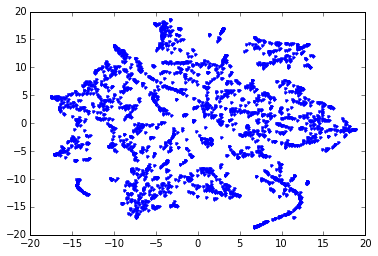

In [20]:
%time course_topic_results = t_SNE_dimension_reduction(course_topic_results)


#### Visualization

In [21]:
def from_RGB_to_hex(tup):
    tup = [x*255 for x in tup]
    return '#%02x%02x%02x' % (tup[0], tup[1], tup[2])

In [22]:
from bokeh.plotting import *
from bokeh.models import HoverTool, PanTool, WheelZoomTool, ResetTool
from seaborn import color_palette

def bokeh_visualization(df, num_entries_to_color=10):

    df['color'] = ['navy' for x in range(df.shape[0])]
   
    topics = df.columns[1:]
    colors = color_palette('Set2', 8) + color_palette('Set1', 8) + color_palette('Set3', 4)
    colors = [from_RGB_to_hex(color) for color in colors]
    color_dic = dict(zip(topics, colors[:len(topics)]))
    color_dic['navy'] = 'navy'
    color_dic_rev = {}
    for key, value in color_dic.items():
        color_dic_rev[value] = key
        
    for col in df.columns:
        if col not in [df.columns[0], 'tsne_1', 'tsne_2', 'color']:
            df.sort(col, ascending=False, inplace=True)
            df['color'].iloc[:num_entries_to_color] = col
        
    df.color = df.color.apply(lambda x: color_dic[x])
    
    
    output_file("t_SNE_decomposition_of_attration_topics.html")

    hover = HoverTool(
        tooltips = [("Name", "@desc"),
        ])


    p = figure(plot_width=1000, plot_height=1000, tools=[hover, PanTool(), WheelZoomTool(), ResetTool()],
                   title="t_SNE Decomposition of Courses")

    for color in df.color.unique():
        data_to_plot = df.loc[df.color == color]

        source = ColumnDataSource(
            data=dict(
                x=data_to_plot.tsne_1.values.tolist(),
                y=data_to_plot.tsne_2.values.tolist(),
                desc=data_to_plot.iloc[:,0].values.tolist(),
            )
        )
        fill_color = data_to_plot.color.values.tolist()
        if color == 'navy':
            p.circle('x', 'y', size=18, source=source, legend='Mixed Theme', fill_color=fill_color, line_color='#FFFFFF')
        else:
            p.circle('x', 'y', size=18, source=source, legend=color_dic_rev[color], fill_color=fill_color, line_color='#FFFFFF')

    show(p) 

In [24]:
bokeh_visualization(course_topic_results, 200)

In [66]:
course_topic_results.loc[course_topic_results.course_name == 'Udemy_Beginning Scala Programming ']

,course_name,Museum/exhibition,Kayak/island/dolphin,Guided tours,Family/kid/parks,Architecture/history,Travel transportation,Performance/theater,Food/restaurants,Shopping/stores,...,Activities/adventures,Beach/surfing,Park/garden/nature,Temple/ruin/cave,Good view from the top,Art gallaries,Bar/night life,tsne_1,tsne_2,color
2720,Udemy_Beginning Scala Programming,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,-4.445476,-2.279865,navy


In [7]:
i = randint(0,700)
course_name = course_topic_results.loc[course_topic_results['Museum/exhibition'] == '0.05'].iloc[i].course_name
print course_name
print Udemy_Coursera_combined_train[course_name]
Udemy_CD.loc[Udemy_CD.course_name == course_name]

NameError: name 'course_topic_results' is not defined

In [6]:
Udemy_CD.loc[Udemy_CD.course_name == 'Learning MySQL5 - An Easy Way To Master MySQL']

,Unnamed: 0,Unnamed: 0.1,course_des,course_name,curriculum,rate_count,requirements,what_you_get,who_should_attend,training_string,site_course_name
944,944,7243,MySQL is the world's most popular relational ...,Learning MySQL5 - An Easy Way To Master MySQL,,\n 24 ratin...,n/a,Over 91 lectures and 6.5 hours of content! \n,n/a,MySQL is the world's most popular relational ...,Udemy_Learning MySQL5 - An Easy Way To Master ...


In [127]:
course_name

u'Udemy_Learning MySQL5 - An Easy Way To Master MySQL'

In [95]:
Udemy_Coursera_combined_train

{u'Udemy_Persuasion with Class, Negotiation with Style': u'a each video a or and then into great detail into how you can that clock in just under is well suit for who wish to not their and prowess but also to their you should take if you are interest in use posit approach to and be heard when you might be disregard turn what are often roadblock in and into point keep the move forward with a posit tone section is a overview of the and by view section student will be section student are some of by view section student will be section student will familiar with more progress on by view section student will be section student will with familiar with the distinct between object truth and subject truth by view section student will be \t in section student will learn about last to the understand of by view section student will be section student will learn about last to the understand of by view section student will be section student will learn about last to the understand of by view section

In [ ]:
course_name

In [65]:
sum(course_topic_results['Museum/exhibition'] == 0.05)

0

In [60]:
Udemy_Coursera_combined_train['Udemy_Beginning Scala Programming']

{u'Udemy_Persuasion with Class, Negotiation with Style': u'a each video a or and then into great detail into how you can that clock in just under is well suit for who wish to not their and prowess but also to their you should take if you are interest in use posit approach to and be heard when you might be disregard turn what are often roadblock in and into point keep the move forward with a posit tone section is a overview of the and by view section student will be section student are some of by view section student will be section student will familiar with more progress on by view section student will be section student will with familiar with the distinct between object truth and subject truth by view section student will be \t in section student will learn about last to the understand of by view section student will be section student will learn about last to the understand of by view section student will be section student will learn about last to the understand of by view section

In [48]:
Udemy_train['Udemy_Beginning Scala Programming ']

nan

In [59]:
Udemy_CD.loc[Udemy_CD.course_name == 'Beginning Scala Programming '].requirements

array([u' A basic understanding of programming \n'], dtype=object)

In [26]:
count = 0

for v in Udemy_Coursera_combined_train.values():
    count += len(v)

count

6926725